<a href="https://colab.research.google.com/github/utkarsh0702/Tensorflow/blob/master/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
from tensorflow import keras
import zipfile
from google.colab import files
import pandas as pd
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['figure.figsize'] = (10,8)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
local_zip= '/content/drive/My Drive/datasets/dog-breed-identification.zip'
zip_ref= zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
df= pd.read_csv('labels.csv')
df

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


# Data Preprocessing

**Choosing specific Dog Breeds**

In [8]:
breeds=['beagle', 'chihuahua', 'doberman','french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound','tibetan_mastiff']
df1 = df.loc[df['breed'].apply(lambda x: any([k in x for k in breeds]))]
df1.head(10)

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45,doberman
25,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
82,01f429667104c0c5a5f321700f15435c,malamute
84,0206c12e8984e3c8a166cc272de25d6f,chihuahua
92,023e4e28415506e0deddcbd8f8bdab29,pug
97,02508e76981e1ba059d785704b4c480c,pug


In [9]:
# added .jpg at the end of each object in id column
df1.id = df1.id + '.jpg'

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
df1['breed'].value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

In [11]:
# breed_number = {'beagle':0, 'chihuahua':1, 'doberman':2,'french_bulldog':3, 'golden_retriever':4,
#                    'malamute':5, 'pug':6, 'saint_bernard':7, 'scottish_deerhound':8,'tibetan_mastiff':9}
# for i in breed_number:
#   df1['breed'].replace(i, breed_number[i], inplace = True)
# df1

In [12]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df1,
    directory="train/",
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    batch_size=32, 
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df1,
    directory="train/",
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    batch_size=32,
    subset="validation")

Found 757 validated image filenames belonging to 10 classes.
Found 84 validated image filenames belonging to 10 classes.


# Transfer Learning with ResNet50

In [13]:
feature_extractor = keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')
feature_extractor.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

# Finding a suitable learning rate

In [20]:
keras.backend.clear_session()

model= keras.Sequential([
                         feature_extractor,
                         keras.layers.GlobalAveragePooling2D(),
                         keras.layers.Flatten(),
                         keras.layers.Dense(128, activation="relu"),
                         keras.layers.Dropout(0.4),
                         keras.layers.Dense(64, activation="relu"),
                         keras.layers.Dropout(0.4),
                         keras.layers.Dense(10, activation= "sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [21]:
num_layers= 6
feature_extractor.trainable= True;
for Layers in model.layers[-num_layers:]:
  Layers.trainable= True

In [16]:
# STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
# STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

# print("Train step size:", STEP_SIZE_TRAIN)
# print("Validation step size:", STEP_SIZE_VAL)

# train_generator.reset()
# validation_generator.reset()

In [22]:
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5*10**(x/20))
checkpoint = keras.callbacks.ModelCheckpoint('dog_breed_classifier_model.h5', 
                                             monitor='val_accuracy', 
                                             verbose=1, save_best_only=True, 
                                             mode='max', save_weights_only=True)

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=1e-5),
    loss= keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [23]:
history = model.fit(train_generator,
                    validation_data=validation_generator, verbose=1,
                    epochs=50, callbacks=[lr_schedular, checkpoint])

Epoch 1/150
24/24 [==============================] - 15s 418ms/step - loss: 2.4289 - accuracy: 0.1124 - val_loss: 2.3831 - val_accuracy: 0.0476

Epoch 00001: val_accuracy improved from -inf to 0.04762, saving model to dog_breed_classifier_model.h5
Epoch 2/150
24/24 [==============================] - 9s 384ms/step - loss: 2.2816 - accuracy: 0.1552 - val_loss: 2.2765 - val_accuracy: 0.1310

Epoch 00002: val_accuracy improved from 0.04762 to 0.13095, saving model to dog_breed_classifier_model.h5
Epoch 3/150
24/24 [==============================] - 9s 378ms/step - loss: 2.1943 - accuracy: 0.1919 - val_loss: 2.1994 - val_accuracy: 0.1905

Epoch 00003: val_accuracy improved from 0.13095 to 0.19048, saving model to dog_breed_classifier_model.h5
Epoch 4/150
24/24 [==============================] - 9s 370ms/step - loss: 2.1119 - accuracy: 0.2223 - val_loss: 2.1100 - val_accuracy: 0.2738

Epoch 00004: val_accuracy improved from 0.19048 to 0.27381, saving model to dog_breed_classifier_model.h5
Ep

In [24]:
val_acc= max(history.history['val_accuracy'])
val_accuracy= history.history['val_accuracy']
index=val_accuracy.index(val_acc)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index: 
    lr=i
    break
  count+=1
print(lr)
print(val_acc)

5.6234134e-05
0.5714285969734192


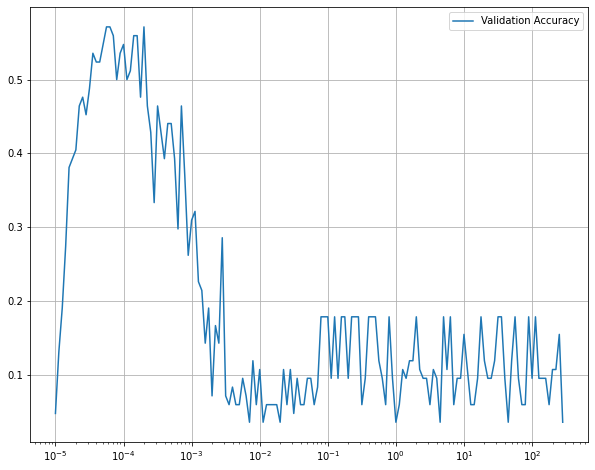

In [26]:
lrs= 1e-5*(10**(np.arange(50)/20))
plt.semilogx(lrs, history.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='best')
plt.grid(True)

# Model Training

In [28]:
keras.backend.clear_session()

model.load_weights('dog_breed_classifier_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [29]:
num_layers= 6
for Layers in model.layers[-num_layers:]:
  Layers.trainable= True

In [ ]:
# STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
# STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

# print("Train step size:", STEP_SIZE_TRAIN)
# print("Validation step size:", STEP_SIZE_VAL)

# train_generator.reset()
# validation_generator.reset()

Train step size: 24
Validation step size: 3


In [30]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=lr),
    loss= keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [31]:
# # a check point callback to save our best weights
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', 
                                             verbose=1, save_best_only=True, 
                                             mode='max') #save_weights_only=True)

# # a reducing lr callback to reduce lr when val_accuracy doesn't increase
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.4,
#                                               patience=2, verbose=1, mode='auto',
#                                               min_delta=0.001, cooldown=2, min_lr=1e-5)


In [32]:
history = model.fit_generator(train_generator,
                              # steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=validation_generator, verbose=1,
                              # validation_steps=STEP_SIZE_VAL,
                              epochs=50, callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
24/24 [==============================] - 15s 426ms/step - loss: 0.2676 - accuracy: 0.9437 - val_loss: 1.6613 - val_accuracy: 0.5476

Epoch 00001: val_accuracy improved from -inf to 0.54762, saving model to model.h5
Epoch 2/50
24/24 [==============================] - 9s 388ms/step - loss: 0.2017 - accuracy: 0.9516 - val_loss: 1.6453 - val_accuracy: 0.5476

Epoch 00002: val_accuracy did not improve from 0.54762
Epoch 3/50
24/24 [==============================] - 9s 379ms/step - loss: 0.2063 - accuracy: 0.9410 - val_loss: 1.6714 - val_accuracy: 0.5476

Epoch 00003: val_accuracy did not improve from 0.54762
Epoch 4/50
24/24 [==============================] - 9s 369ms/step - loss: 0.1566 - accuracy: 0.9582 - val_loss: 1.6101 - val_accuracy: 0.5476

Epoch 00004: val_accuracy did not improve from 0.54762
Epoch 5/50
24/24 [==============================] - 9s 364ms/step - loss: 0.1347 - accuracy: 0.9658 - val_loss: 1.6072 - val_accuracy: 0.5476

Epoch 00005: val_accuracy did not imp

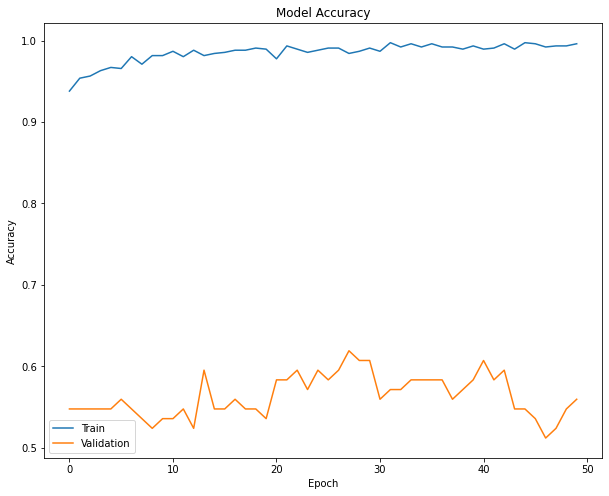

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# Prediction

In [ ]:
uploaded= files.upload()

for fn in uploaded.keys():
  # predict image
  path='/content/' + fn
  img= image.load_img(path, target_size=(300,300))
  plt.axis('off')
  plt.imshow(img)
  plt.show()
  x= image.img_to_array(img)
  x= np.expand_dims(x, axis=0)
  
  images= np.vstack([x])
  classes= model.predict(images, batch_size=10)
  print(classes)

# Model Saving

In [34]:
model.save("dog_breed_model.h5")